

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':20},
        'lenet':{'dropout':0.2, 'epochs':20},
        'custom':{'dropout':0.2, 'epochs':20},
        'vgg':{'dropout':0.1, 'epochs':20, 'learning_rate':0.001},
        'resnet':{'dropout':0.2, 'epochs':20},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(10000, 32, 32, 3) (10000,)
(10000, 32, 32, 3) (10000,)


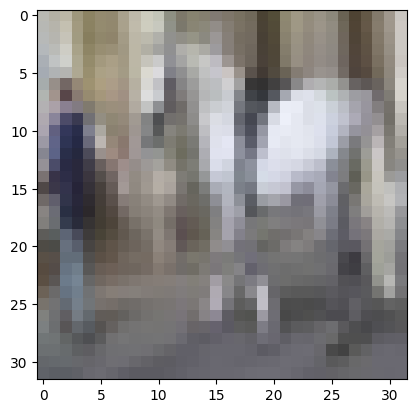

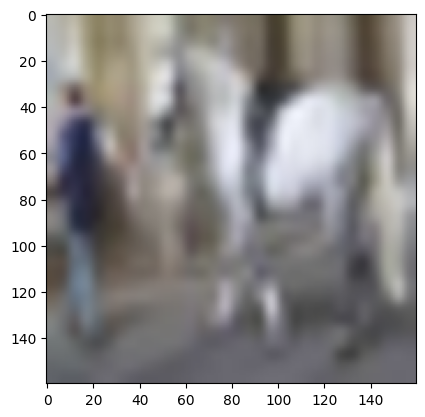

(32, 32, 3) (160, 160, 3)


In [8]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [9]:
train_images = resize_images(train_images, input_shape)
test_images = resize_images(test_images, input_shape)

print(train_images.shape, type(train_images), train_images.dtype)
print(test_images.shape, type(test_images), test_images.dtype) 

(10000, 160, 160, 3) <class 'numpy.ndarray'> uint8
(10000, 160, 160, 3) <class 'numpy.ndarray'> uint8




### Data Explore 

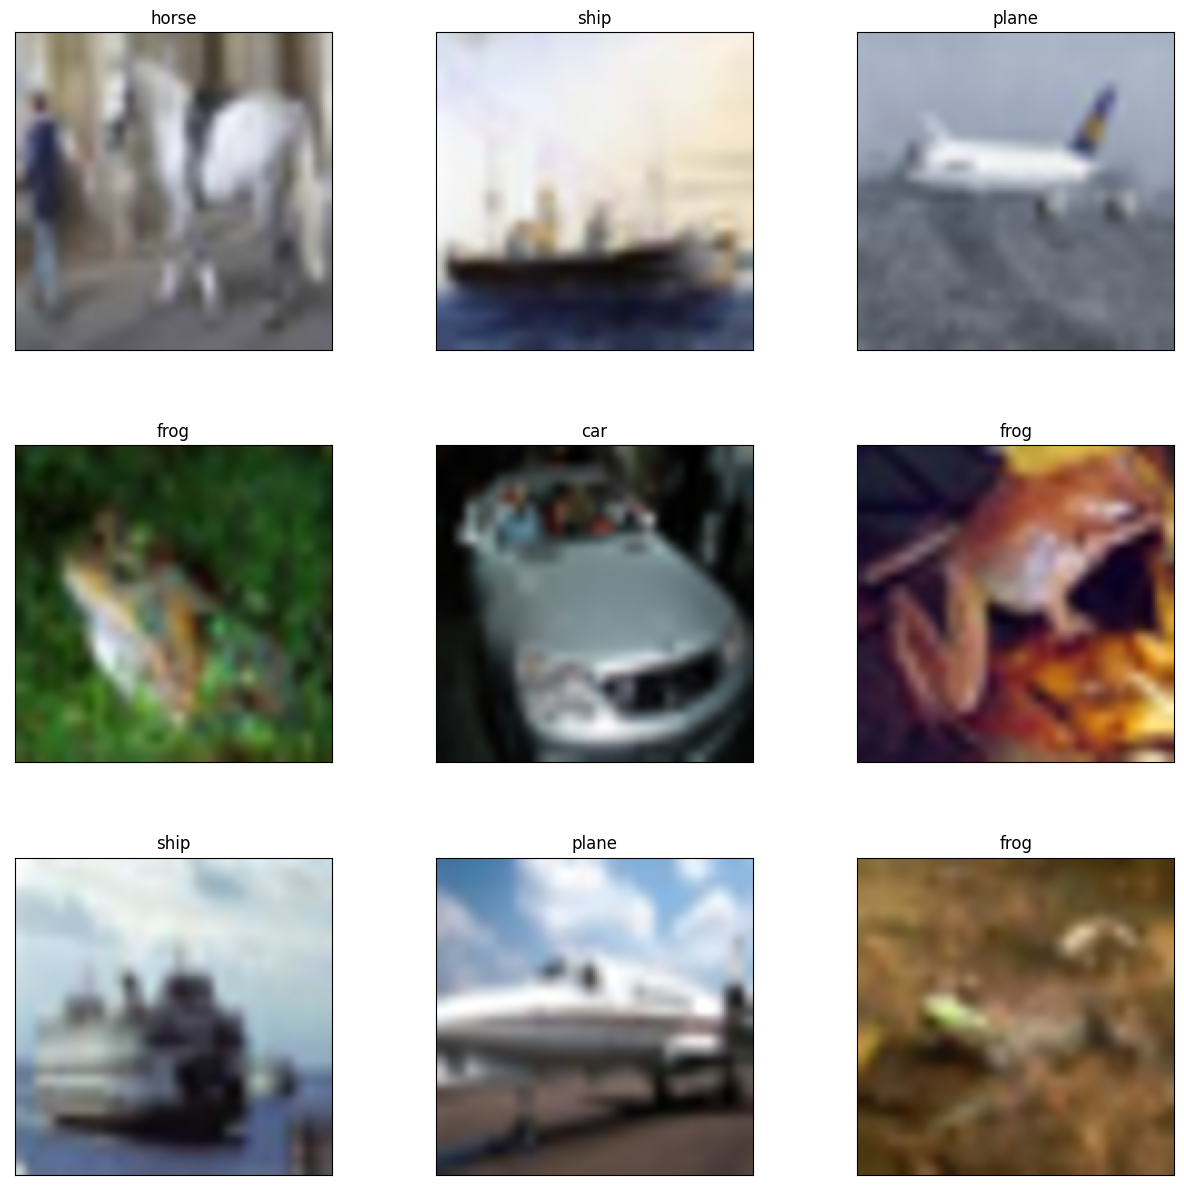

In [10]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

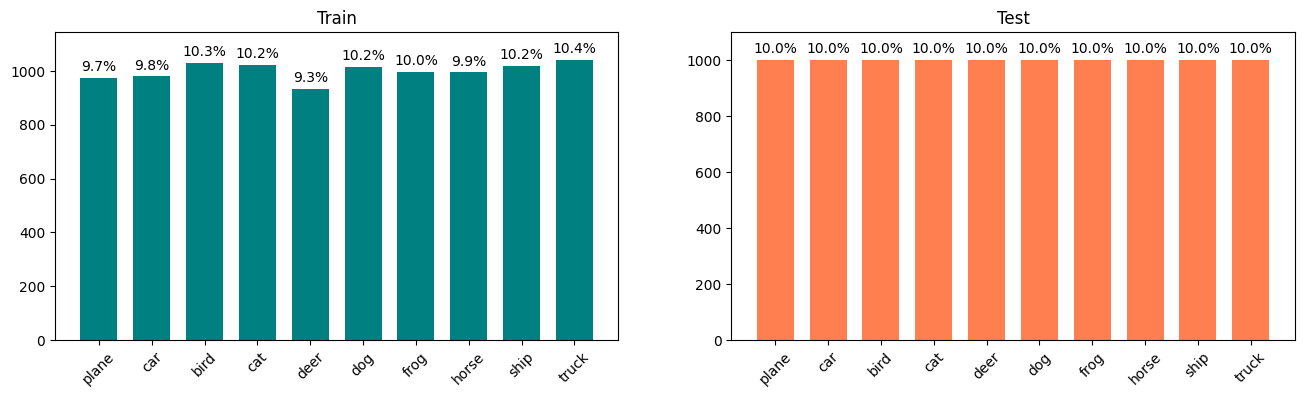

In [11]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [12]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [13]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [14]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 160, 160, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

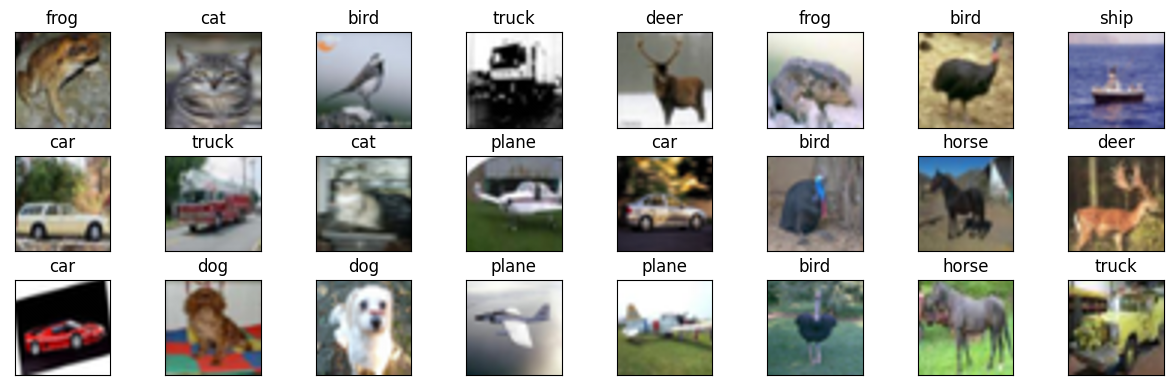

In [15]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [16]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

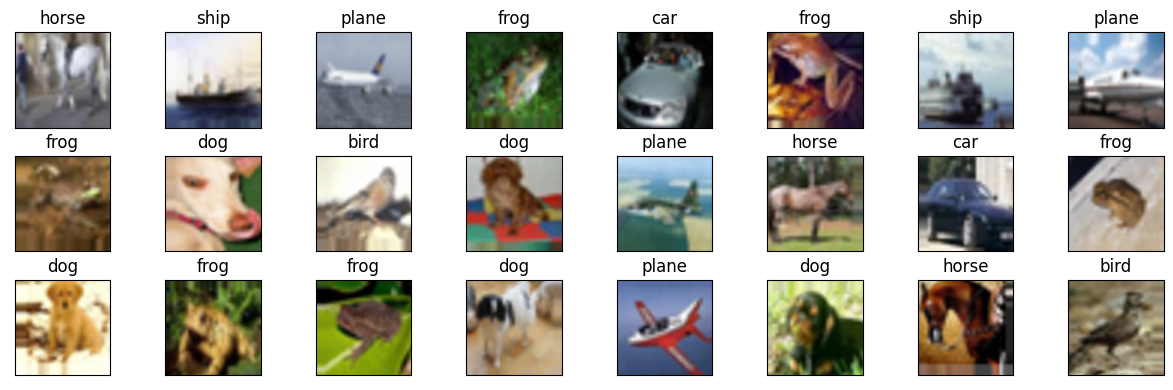

In [17]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

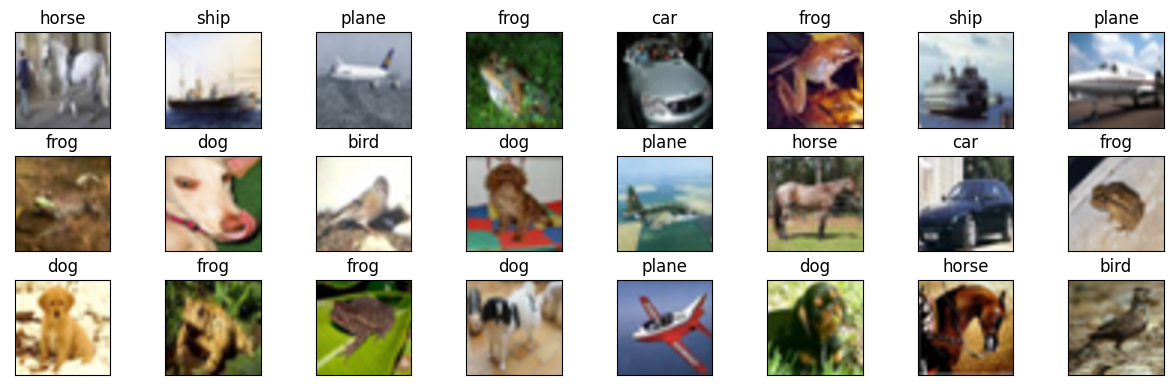

In [18]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [19]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [20]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


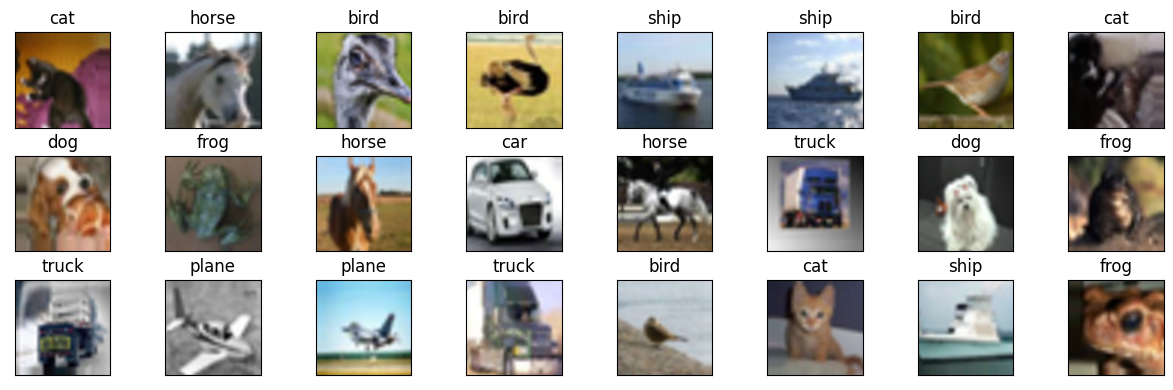

In [21]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-16 05:52:42,603: INFO: model_params.mlp1.dropout=0.1
2022-08-16 05:52:42,603: INFO: model_params.mlp1.layer_count=1
2022-08-16 05:52:42,604: INFO: model_params.mlp1.units=128
2022-08-16 05:52:42,643: INFO: learning_rate=0.001
2022-08-16 05:52:42,643: INFO: model_params.mlp1.clip_value=None
2022-08-16 05:52:42,651: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 9,831,818
Trainable params: 9,831,818
Non-traina

2022-08-16 05:52:42,665: INFO: model_params.mlp1.epochs=20
2022-08-16 05:52:42,666: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1, monitor=val_accuracy)
2022-08-16 05:52:42,666: INFO: steps_per_epoch=312
2022-08-16 05:52:42,667: INFO: start training
2022-08-16 05:52:42,668: INFO: use_class_weight=False


Epoch 1/20
308/312 [============================>.] - ETA: 0s - loss: 18.8363 - accuracy: 0.2239INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:52:47,087: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 4s 12ms/step - loss: 18.7625 - accuracy: 0.2246 - val_loss: 12.0892 - val_accuracy: 0.2629
Epoch 2/20
304/312 [============================>.] - ETA: 0s - loss: 12.1138 - accuracy: 0.2789INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:52:50,132: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 12.0406 - accuracy: 0.2792 - val_loss: 10.2073 - val_accuracy: 0.2764
Epoch 3/20
308/312 [============================>.] - ETA: 0s - loss: 8.2502 - accuracy: 0.3049INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:52:53,185: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 8.2411 - accuracy: 0.3048 - val_loss: 7.3338 - val_accuracy: 0.2815
Epoch 4/20
306/312 [============================>.] - ETA: 0s - loss: 5.4771 - accuracy: 0.3460INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:52:56,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 5.4463 - accuracy: 0.3469 - val_loss: 5.7121 - val_accuracy: 0.3103
Epoch 5/20
302/312 [============================>.] - ETA: 0s - loss: 3.8214 - accuracy: 0.3678INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:52:59,268: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 3.8004 - accuracy: 0.3685 - val_loss: 4.5179 - val_accuracy: 0.3260
Epoch 6/20
306/312 [============================>.] - ETA: 0s - loss: 3.0833 - accuracy: 0.3919INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:53:02,346: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 3.0790 - accuracy: 0.3924 - val_loss: 3.6755 - val_accuracy: 0.3399
Epoch 7/20
302/312 [============================>.] - ETA: 0s - loss: 2.4997 - accuracy: 0.4235INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:53:05,595: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 2.4870 - accuracy: 0.4235 - val_loss: 3.1696 - val_accuracy: 0.3601
Epoch 8/20
312/312 [==============================] - ETA: 0s - loss: 1.9885 - accuracy: 0.4591INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:53:08,660: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 1.9885 - accuracy: 0.4591 - val_loss: 2.6529 - val_accuracy: 0.3779
Epoch 9/20
312/312 [==============================] - 2s 7ms/step - loss: 1.7596 - accuracy: 0.4727 - val_loss: 2.4579 - val_accuracy: 0.3770
Epoch 10/20
306/312 [============================>.] - ETA: 0s - loss: 1.6878 - accuracy: 0.4904INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


2022-08-16 05:53:14,006: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 1.6875 - accuracy: 0.4905 - val_loss: 2.4631 - val_accuracy: 0.3960
Epoch 11/20
312/312 [==============================] - 2s 7ms/step - loss: 1.6467 - accuracy: 0.4983 - val_loss: 2.6222 - val_accuracy: 0.3756
Epoch 12/20
312/312 [==============================] - 2s 7ms/step - loss: 1.6490 - accuracy: 0.4959 - val_loss: 2.5383 - val_accuracy: 0.3756
Epoch 13/20
312/312 [==============================] - 2s 7ms/step - loss: 1.6256 - accuracy: 0.5035 - val_loss: 2.6036 - val_accuracy: 0.3692
Epoch 14/20
312/312 [==============================] - 2s 7ms/step - loss: 1.7238 - accuracy: 0.4932 - val_loss: 2.8037 - val_accuracy: 0.3753
Epoch 15/20
312/312 [==============================] - 2s 7ms/step - loss: 1.7707 - accuracy: 0.4911 - val_loss: 2.9142 - val_accuracy: 0.3701
Epoch 16/20
312/312 [==============================] - 2s 7ms/step - loss: 1.7917 - accuracy: 0.4942 - val_loss: 2.6747 - val_accuracy: 0.3836
Epoch 17/2

2022-08-16 05:53:37,042: INFO: finish training [elapsed time: 54.38 seconds]


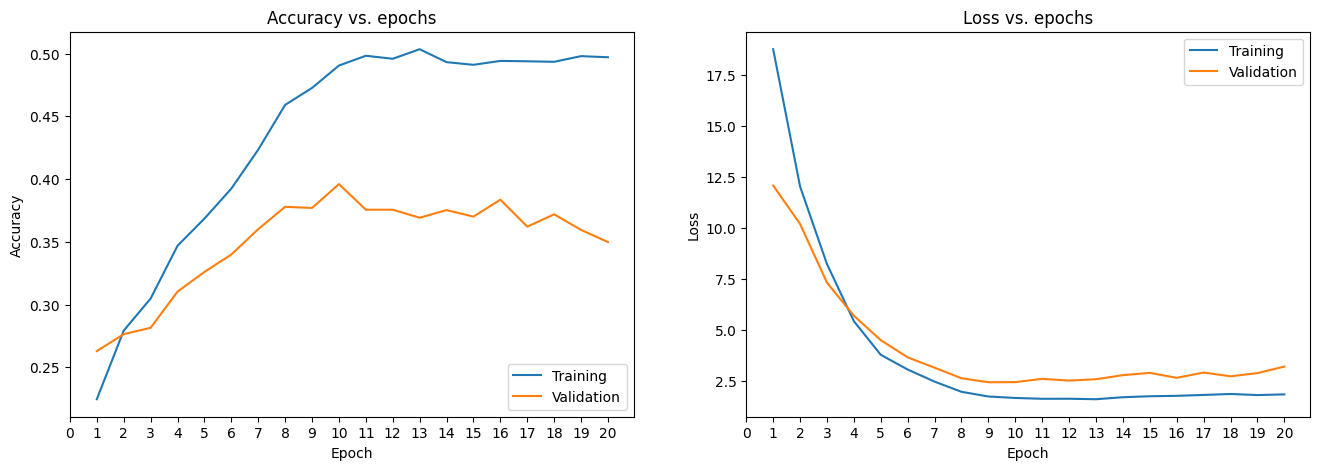

2022-08-16 05:53:37,478: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 05:53:48,025: INFO: test loss:2.4631
2022-08-16 05:53:48,026: INFO: test accuracy:0.3960
2022-08-16 05:53:48,027: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 05:53:48,029: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 05:53:48,029: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 05:53:48,030: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 1s 2ms/step


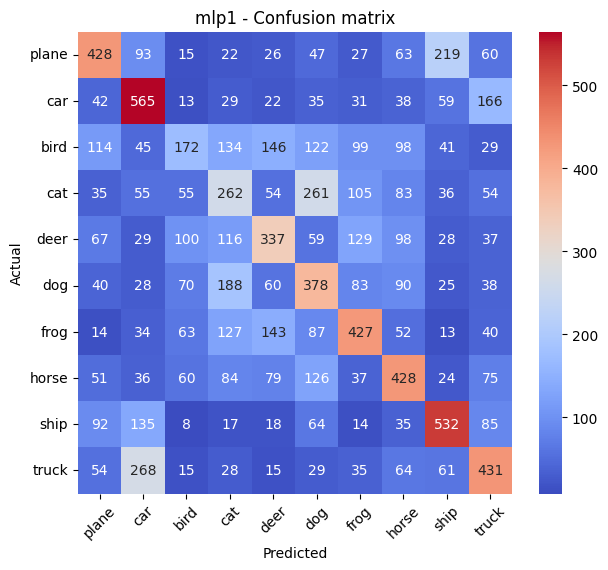

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_1000.ipynb        9831818        54.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 05:53      1.4277     2.4631          0.5565          0.396   

   train_auc  test_auc  
1     0.8958    0.7945

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 05:53:51,208: INFO: model_params.lenet1.dropout=0.2
2022-08-16 05:53:51,296: INFO: learning_rate=0.001
2022-08-16 05:53:51,297: INFO: model_params.lenet1.clip_value=None
2022-08-16 05:53:51,303: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 6)         0    

2022-08-16 05:53:51,332: INFO: model_params.lenet1.epochs=20
2022-08-16 05:53:51,333: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1, monitor=val_accuracy)
2022-08-16 05:53:51,333: INFO: steps_per_epoch=312
2022-08-16 05:53:51,334: INFO: start training
2022-08-16 05:53:51,335: INFO: use_class_weight=False


Epoch 1/20
311/312 [============================>.] - ETA: 0s - loss: 2.5273 - accuracy: 0.1567

2022-08-16 05:53:59,578: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:00,164: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 9s 24ms/step - loss: 2.5257 - accuracy: 0.1571 - val_loss: 6.9575 - val_accuracy: 0.1508
Epoch 2/20
311/312 [============================>.] - ETA: 0s - loss: 2.1480 - accuracy: 0.1945

2022-08-16 05:54:06,517: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:07,108: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 2.1471 - accuracy: 0.1948 - val_loss: 2.5850 - val_accuracy: 0.2432
Epoch 3/20
311/312 [============================>.] - ETA: 0s - loss: 2.0549 - accuracy: 0.2353

2022-08-16 05:54:13,456: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:14,049: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 2.0536 - accuracy: 0.2358 - val_loss: 2.2011 - val_accuracy: 0.2757
Epoch 4/20
311/312 [============================>.] - ETA: 0s - loss: 1.9327 - accuracy: 0.2717

2022-08-16 05:54:20,658: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:21,253: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 23ms/step - loss: 1.9317 - accuracy: 0.2721 - val_loss: 2.0144 - val_accuracy: 0.3302
Epoch 5/20
311/312 [============================>.] - ETA: 0s - loss: 1.8364 - accuracy: 0.3044

2022-08-16 05:54:27,607: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:28,183: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.8353 - accuracy: 0.3047 - val_loss: 1.9152 - val_accuracy: 0.3617
Epoch 6/20
310/312 [============================>.] - ETA: 0s - loss: 1.7649 - accuracy: 0.3341

2022-08-16 05:54:34,564: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:35,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.7631 - accuracy: 0.3346 - val_loss: 1.7291 - val_accuracy: 0.3886
Epoch 7/20
311/312 [============================>.] - ETA: 0s - loss: 1.6974 - accuracy: 0.3553

2022-08-16 05:54:41,770: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:42,356: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 23ms/step - loss: 1.6965 - accuracy: 0.3558 - val_loss: 1.7101 - val_accuracy: 0.3890
Epoch 8/20
311/312 [============================>.] - ETA: 0s - loss: 1.6382 - accuracy: 0.3819

2022-08-16 05:54:48,736: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:54:49,324: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.6372 - accuracy: 0.3824 - val_loss: 1.6724 - val_accuracy: 0.4130
Epoch 9/20
312/312 [==============================] - 5s 17ms/step - loss: 1.5685 - accuracy: 0.4192 - val_loss: 1.7108 - val_accuracy: 0.4102
Epoch 10/20
310/312 [============================>.] - ETA: 0s - loss: 1.5374 - accuracy: 0.4265

2022-08-16 05:55:00,854: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:55:01,425: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.5360 - accuracy: 0.4270 - val_loss: 1.6644 - val_accuracy: 0.4256
Epoch 11/20
312/312 [==============================] - 5s 17ms/step - loss: 1.4662 - accuracy: 0.4570 - val_loss: 1.6991 - val_accuracy: 0.4172
Epoch 12/20
311/312 [============================>.] - ETA: 0s - loss: 1.3883 - accuracy: 0.4783

2022-08-16 05:55:13,212: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:55:13,796: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 23ms/step - loss: 1.3880 - accuracy: 0.4784 - val_loss: 1.5904 - val_accuracy: 0.4519
Epoch 13/20
312/312 [==============================] - 5s 17ms/step - loss: 1.3394 - accuracy: 0.5004 - val_loss: 1.5545 - val_accuracy: 0.4516
Epoch 14/20
312/312 [==============================] - 5s 17ms/step - loss: 1.2866 - accuracy: 0.5197 - val_loss: 1.6809 - val_accuracy: 0.4353
Epoch 15/20
309/312 [============================>.] - ETA: 0s - loss: 1.2355 - accuracy: 0.5392

2022-08-16 05:55:30,528: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:55:31,116: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.2350 - accuracy: 0.5396 - val_loss: 1.6073 - val_accuracy: 0.4593
Epoch 16/20
311/312 [============================>.] - ETA: 0s - loss: 1.1963 - accuracy: 0.5579

2022-08-16 05:55:37,494: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:55:38,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.1952 - accuracy: 0.5582 - val_loss: 1.6565 - val_accuracy: 0.4607
Epoch 17/20
312/312 [==============================] - 5s 17ms/step - loss: 1.1543 - accuracy: 0.5736 - val_loss: 1.6552 - val_accuracy: 0.4606
Epoch 18/20
310/312 [============================>.] - ETA: 0s - loss: 1.1334 - accuracy: 0.5795

2022-08-16 05:55:49,862: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:55:50,449: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 23ms/step - loss: 1.1315 - accuracy: 0.5802 - val_loss: 1.5993 - val_accuracy: 0.4716
Epoch 19/20
312/312 [==============================] - 5s 17ms/step - loss: 1.0656 - accuracy: 0.6048 - val_loss: 1.7871 - val_accuracy: 0.4567
Epoch 20/20
311/312 [============================>.] - ETA: 0s - loss: 1.0569 - accuracy: 0.6132

2022-08-16 05:56:01,997: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


2022-08-16 05:56:02,588: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1/assets


312/312 [==============================] - 7s 22ms/step - loss: 1.0561 - accuracy: 0.6132 - val_loss: 1.6610 - val_accuracy: 0.4762


2022-08-16 05:56:02,656: INFO: finish training [elapsed time: 131.32 seconds]


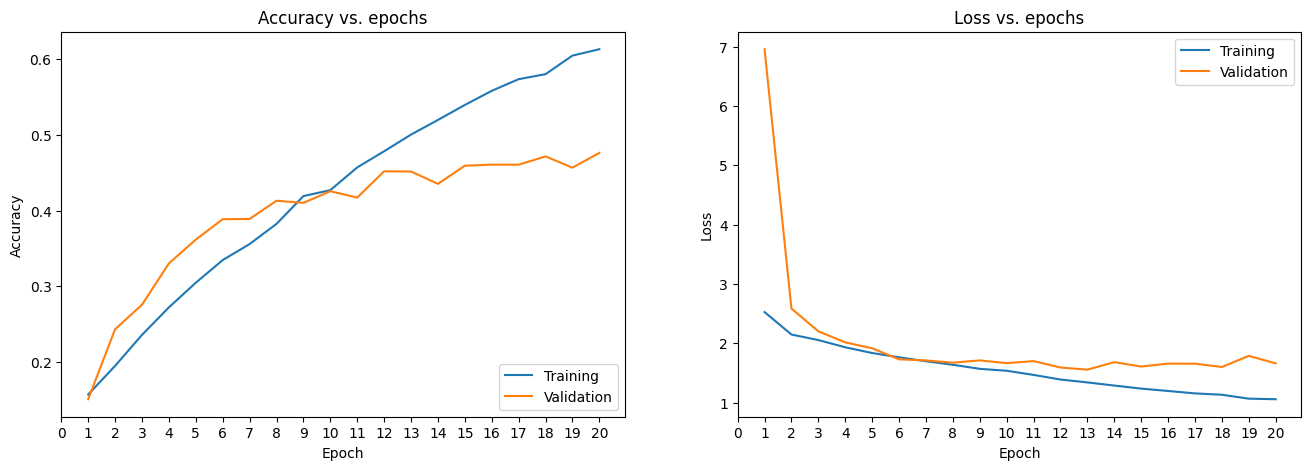

2022-08-16 05:56:03,066: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 4ms/step


2022-08-16 05:56:16,189: INFO: test loss:1.6610
2022-08-16 05:56:16,190: INFO: test accuracy:0.4762
2022-08-16 05:56:16,191: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 05:56:16,192: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 05:56:16,193: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 05:56:16,194: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 05:56:16,195: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 05:56:16,568: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


313/313 [==============================] - 1s 2ms/step


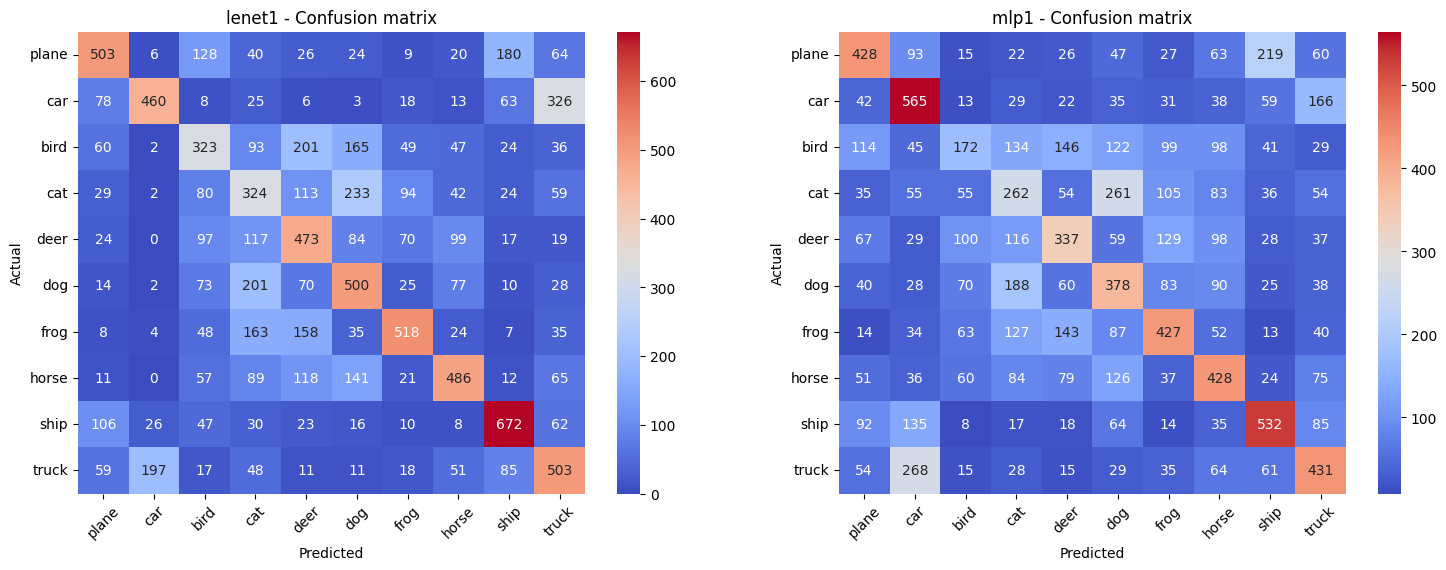

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_1000.ipynb        2786530       131.3   
2       mlp1  cifar10_0816_cnt_1000.ipynb        9831818        54.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 05:56      0.7871     1.6610          0.7168         0.4762   
2  2022-08-16 05:53      1.4277     2.4631          0.5565         0.3960   

   train_auc  test_auc  
1     0.9641    0.8629  
2     0.8958    0.7945

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

2022-08-16 05:56:23,661: INFO: model_params.custom1.dropout=0.2
2022-08-16 05:56:23,762: INFO: learning_rate=0.001
2022-08-16 05:56:23,762: INFO: model_params.custom1.clip_value=None
2022-08-16 05:56:23,768: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 32)        0   

2022-08-16 05:56:23,801: INFO: model_params.custom1.epochs=20
2022-08-16 05:56:23,802: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/custom1, monitor=val_accuracy)
2022-08-16 05:56:23,803: INFO: steps_per_epoch=312
2022-08-16 05:56:23,803: INFO: start training
2022-08-16 05:56:23,804: INFO: use_class_weight=False


Epoch 1/20
311/312 [============================>.] - ETA: 0s - loss: 2.3946 - accuracy: 0.1371

2022-08-16 05:56:35,590: INFO: finish training [elapsed time: 11.79 seconds]


KeyboardInterrupt: 

### VGG

In [ ]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

In [ ]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


In [ ]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [25]:
input_shape = [160, 160, 3]

def resize(shape):
    def resize_(x):
        return tf.image.resize(x, shape)
    return resize_

In [26]:
preprocess_fun =  [rescale]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


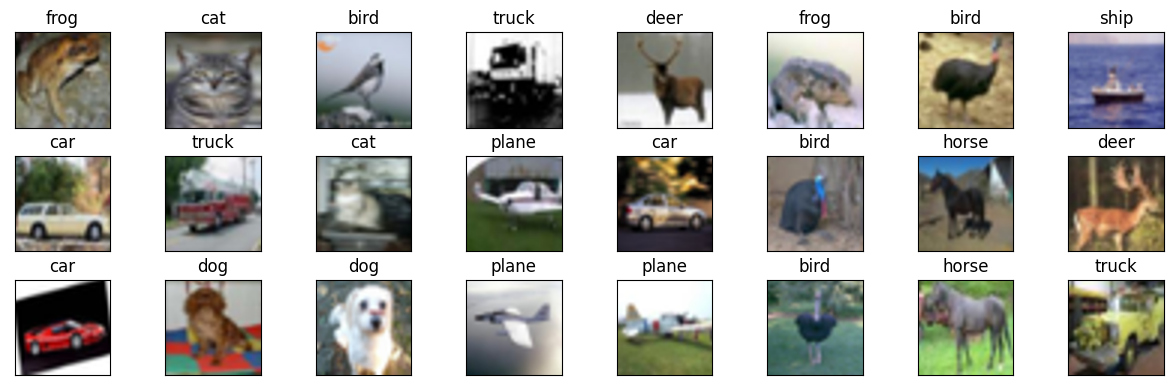

In [27]:
sample_images1 = resize(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

#### MobileNet V2

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [29]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-16 07:50:31,346: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-16 07:50:31,348: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-16 07:50:31,360: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Den

2022-08-16 07:50:46,053: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 07:50:46,054: INFO: steps_per_epoch=312
2022-08-16 07:50:46,055: INFO: start training
2022-08-16 07:50:46,055: INFO: use_class_weight=False


Epoch 1/10
310/312 [============================>.] - ETA: 0s - loss: 2.0601 - accuracy: 0.3100

2022-08-16 07:51:18,135: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:51:22,740: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 37s 112ms/step - loss: 2.0558 - accuracy: 0.3112 - val_loss: 1.2389 - val_accuracy: 0.6153
Epoch 2/10
310/312 [============================>.] - ETA: 0s - loss: 1.1113 - accuracy: 0.6376

2022-08-16 07:51:53,092: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:51:57,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 35s 113ms/step - loss: 1.1095 - accuracy: 0.6382 - val_loss: 0.8212 - val_accuracy: 0.7531
Epoch 3/10
310/312 [============================>.] - ETA: 0s - loss: 0.8294 - accuracy: 0.7307

2022-08-16 07:52:28,115: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:52:32,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 35s 112ms/step - loss: 0.8284 - accuracy: 0.7312 - val_loss: 0.6737 - val_accuracy: 0.7908
Epoch 4/10
310/312 [============================>.] - ETA: 0s - loss: 0.7023 - accuracy: 0.7702

2022-08-16 07:53:02,455: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:53:07,112: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 34s 110ms/step - loss: 0.7013 - accuracy: 0.7707 - val_loss: 0.6012 - val_accuracy: 0.8082
Epoch 5/10
310/312 [============================>.] - ETA: 0s - loss: 0.6262 - accuracy: 0.7906

2022-08-16 07:53:36,403: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:53:40,738: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 34s 108ms/step - loss: 0.6258 - accuracy: 0.7908 - val_loss: 0.5572 - val_accuracy: 0.8203
Epoch 6/10
310/312 [============================>.] - ETA: 0s - loss: 0.5792 - accuracy: 0.8078

2022-08-16 07:54:10,506: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:54:14,942: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 34s 110ms/step - loss: 0.5788 - accuracy: 0.8074 - val_loss: 0.5293 - val_accuracy: 0.8272
Epoch 7/10
310/312 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.8165

2022-08-16 07:54:44,589: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:54:48,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 34s 109ms/step - loss: 0.5422 - accuracy: 0.8164 - val_loss: 0.5078 - val_accuracy: 0.8330
Epoch 8/10
310/312 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.8251

2022-08-16 07:55:18,712: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:55:23,204: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 34s 110ms/step - loss: 0.5170 - accuracy: 0.8254 - val_loss: 0.4928 - val_accuracy: 0.8374
Epoch 9/10
311/312 [============================>.] - ETA: 0s - loss: 0.4913 - accuracy: 0.8355

2022-08-16 07:56:00,839: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:56:05,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 136ms/step - loss: 0.4910 - accuracy: 0.8357 - val_loss: 0.4800 - val_accuracy: 0.8396
Epoch 10/10
310/312 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.8376

2022-08-16 07:56:38,654: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:56:43,228: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 38s 121ms/step - loss: 0.4763 - accuracy: 0.8378 - val_loss: 0.4696 - val_accuracy: 0.8421


2022-08-16 07:56:44,025: INFO: finish training [elapsed time: 357.97 seconds]


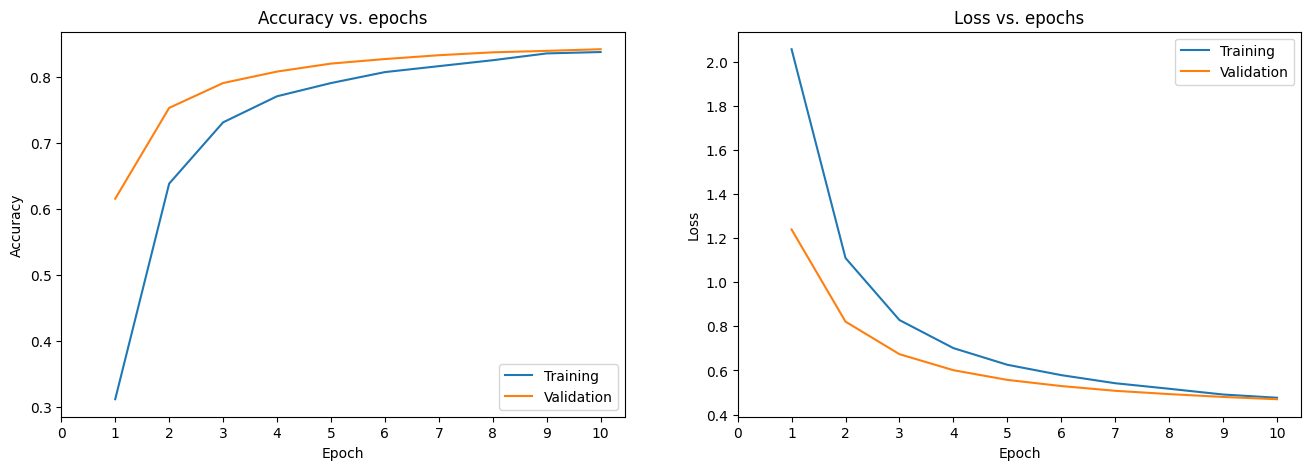

In [31]:
history = helper.train(model, epochs=10)

In [32]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-16 07:56:44,561: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 07:56:44,562: INFO: steps_per_epoch=312
2022-08-16 07:56:44,562: INFO: start training
2022-08-16 07:56:44,563: INFO: use_class_weight=False


Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8514

2022-08-16 07:57:29,994: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:57:35,093: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 51s 147ms/step - loss: 0.4276 - accuracy: 0.8514 - val_loss: 0.3914 - val_accuracy: 0.8673
Epoch 2/10
312/312 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8883

2022-08-16 07:58:14,830: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:58:19,608: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 45s 143ms/step - loss: 0.3284 - accuracy: 0.8883 - val_loss: 0.3640 - val_accuracy: 0.8773
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9096

2022-08-16 07:58:58,217: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:59:03,346: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 44s 140ms/step - loss: 0.2660 - accuracy: 0.9096 - val_loss: 0.3558 - val_accuracy: 0.8812
Epoch 4/10
311/312 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9279

2022-08-16 07:59:41,319: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 07:59:46,145: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 43s 137ms/step - loss: 0.2144 - accuracy: 0.9279 - val_loss: 0.3317 - val_accuracy: 0.8899
Epoch 5/10
311/312 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9406

2022-08-16 08:00:23,990: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 08:00:29,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 43s 138ms/step - loss: 0.1773 - accuracy: 0.9405 - val_loss: 0.3367 - val_accuracy: 0.8900
Epoch 6/10
311/312 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.9525

2022-08-16 08:01:06,297: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 08:01:11,271: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 136ms/step - loss: 0.1401 - accuracy: 0.9524 - val_loss: 0.3388 - val_accuracy: 0.8930
Epoch 7/10
311/312 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9641

2022-08-16 08:01:47,896: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 08:01:53,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 42s 134ms/step - loss: 0.1122 - accuracy: 0.9641 - val_loss: 0.3334 - val_accuracy: 0.8970
Epoch 8/10
312/312 [==============================] - 19s 61ms/step - loss: 0.0912 - accuracy: 0.9712 - val_loss: 0.3454 - val_accuracy: 0.8961
Epoch 9/10
312/312 [==============================] - 30s 97ms/step - loss: 0.0674 - accuracy: 0.9818 - val_loss: 0.3562 - val_accuracy: 0.8963
Epoch 10/10
312/312 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9854

2022-08-16 08:03:24,214: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


2022-08-16 08:03:29,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2/assets


312/312 [==============================] - 47s 151ms/step - loss: 0.0531 - accuracy: 0.9854 - val_loss: 0.3500 - val_accuracy: 0.9001


2022-08-16 08:03:29,941: INFO: finish training [elapsed time: 405.38 seconds]


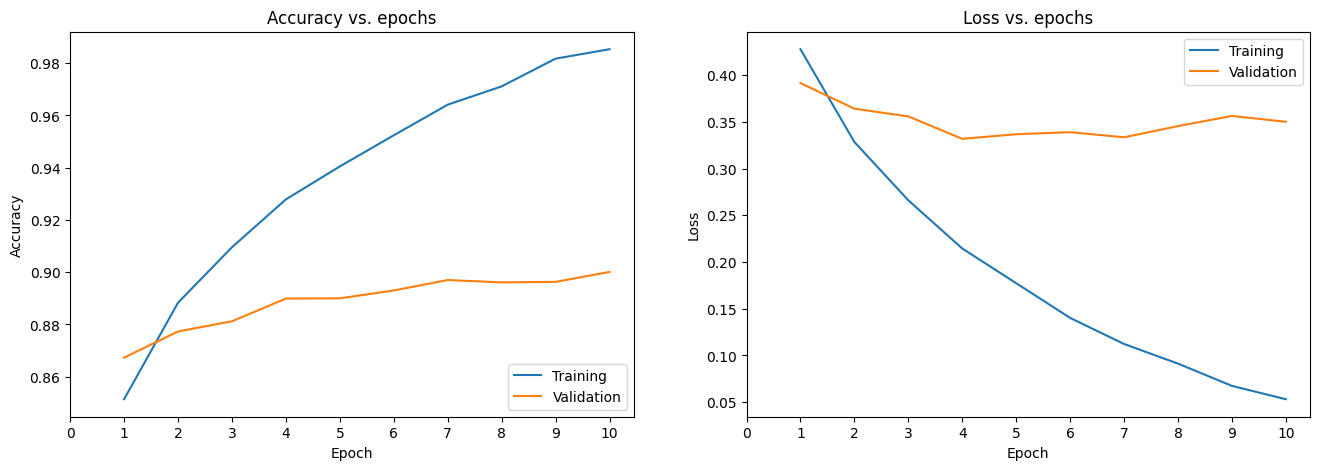

2022-08-16 08:03:30,311: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 7s 21ms/step


2022-08-16 08:04:19,686: INFO: test loss:0.3500
2022-08-16 08:04:19,687: INFO: test accuracy:0.9001
2022-08-16 08:04:19,690: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/results.json
2022-08-16 08:04:19,692: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/results.json
2022-08-16 08:04:19,692: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/default.generator
2022-08-16 08:04:19,694: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000_1/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
202/313 [==================>...........] - ETA: 2s

In [ ]:
history = helper.train(model, epochs=10)
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)